## Problem Description and Data Overview

The goal of this project is to generate high-quality images in the artistic style of Claude Monet using generative deep learning models. This task is inspired by the Kaggle GAN Getting Started competition, which challenges participants to learn the underlying distribution of Monet paintings and generate visually plausible images that resemble impressionist artwork. Model performance is evaluated using a hidden perceptual metric, making visual realism and stylistic consistency central to success.

The dataset consists of two unpaired image domains: approximately 300 Monet paintings and a larger set of real-world photographs. All images are stored as RGB JPEG files with varying resolutions and aspect ratios. Monet images exhibit characteristic stylistic features such as soft edges, saturated color palettes, textured brush-like patterns, and reduced fine-grain detail, while photographs contain sharper edges, higher structural contrast, and more natural color distributions. Prior to training, all images are resized and normalized to a consistent 256×256 spatial resolution with pixel values scaled to the range [−1, 1], enabling stable training across different model architectures.

While the problem is framed as unconditional image generation in the competition, it naturally supports multiple modeling paradigms, including adversarial generation, unpaired image-to-image translation, and denoising-based generative modeling. In this project, three approaches—DCGAN, CycleGAN, and a diffusion-based model—are explored and compared. Together, these models represent distinct generative strategies, allowing for an analysis of how architectural inductive biases, training stability, and computational cost influence both quantitative metrics and perceptual output quality.

## Exploratory Data Analysis

Exploratory analysis indicates that Monet paintings differ from photographs primarily in local texture density, tonal balance, and restrained color saturation, rather than gross pixel-level statistics. While RGB histograms show compression-related spikes at zero intensity, these artifacts do not reflect stylistic content. Sobel edge analysis reveals that Monet images exhibit higher local gradient energy, consistent with visible brush strokes and motivating the use of patch-based discriminators. Luminance and HSV analyses further demonstrate Monet’s emphasis on mid-tones and subdued saturation, guiding conservative augmentation choices. Together, these findings support architectural inductive biases emphasizing local texture modeling and feature-space evaluation over pixel-level normalization.

Found 300 Monet images
Found 7038 Photo images


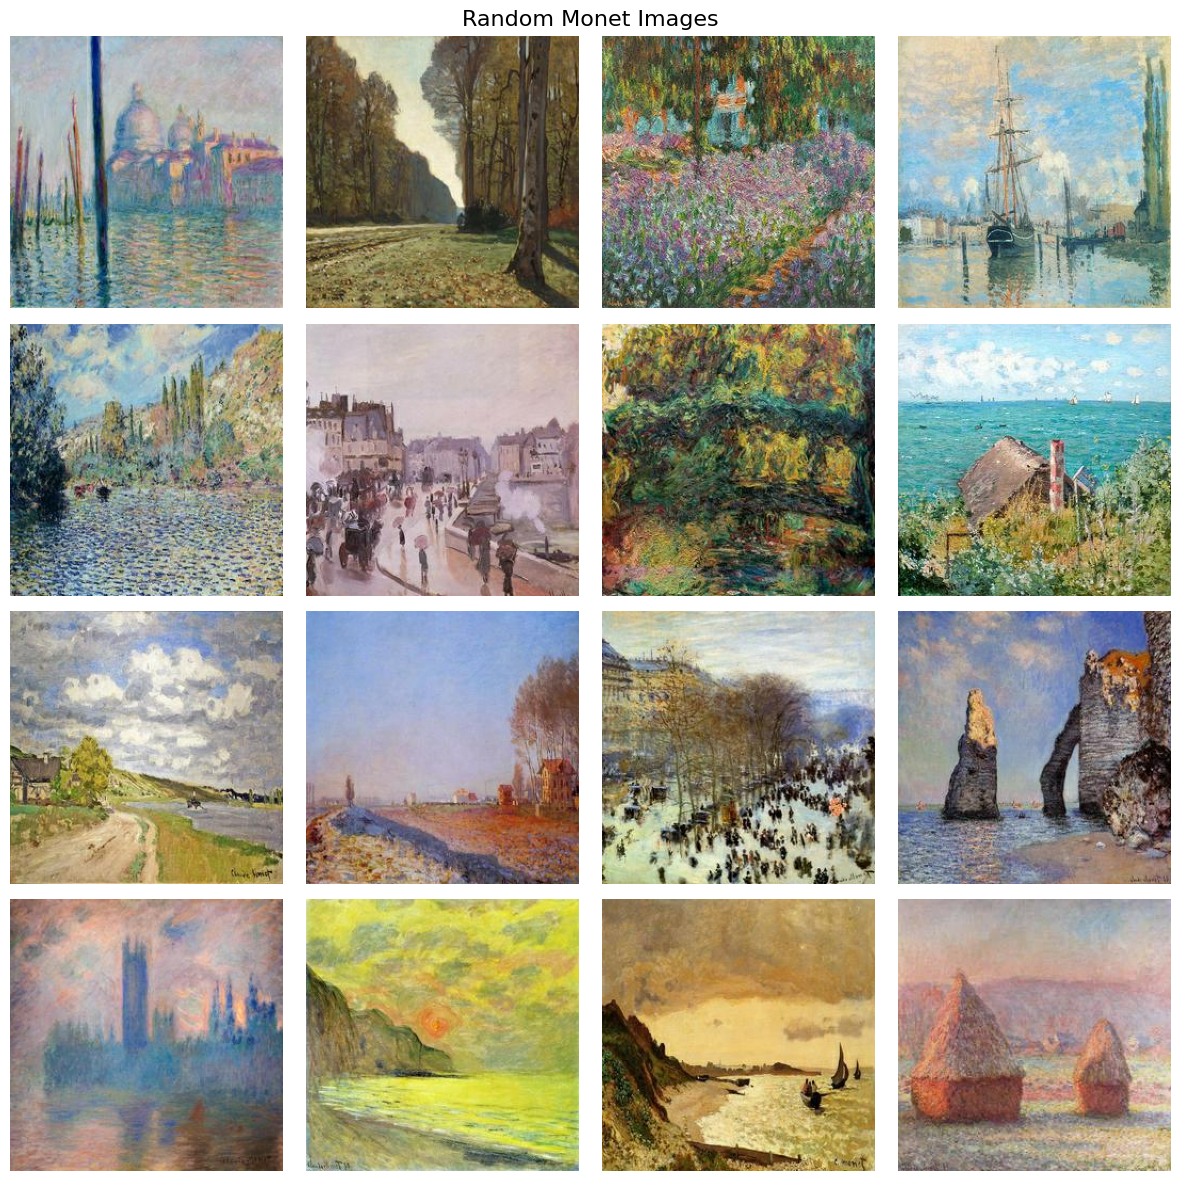

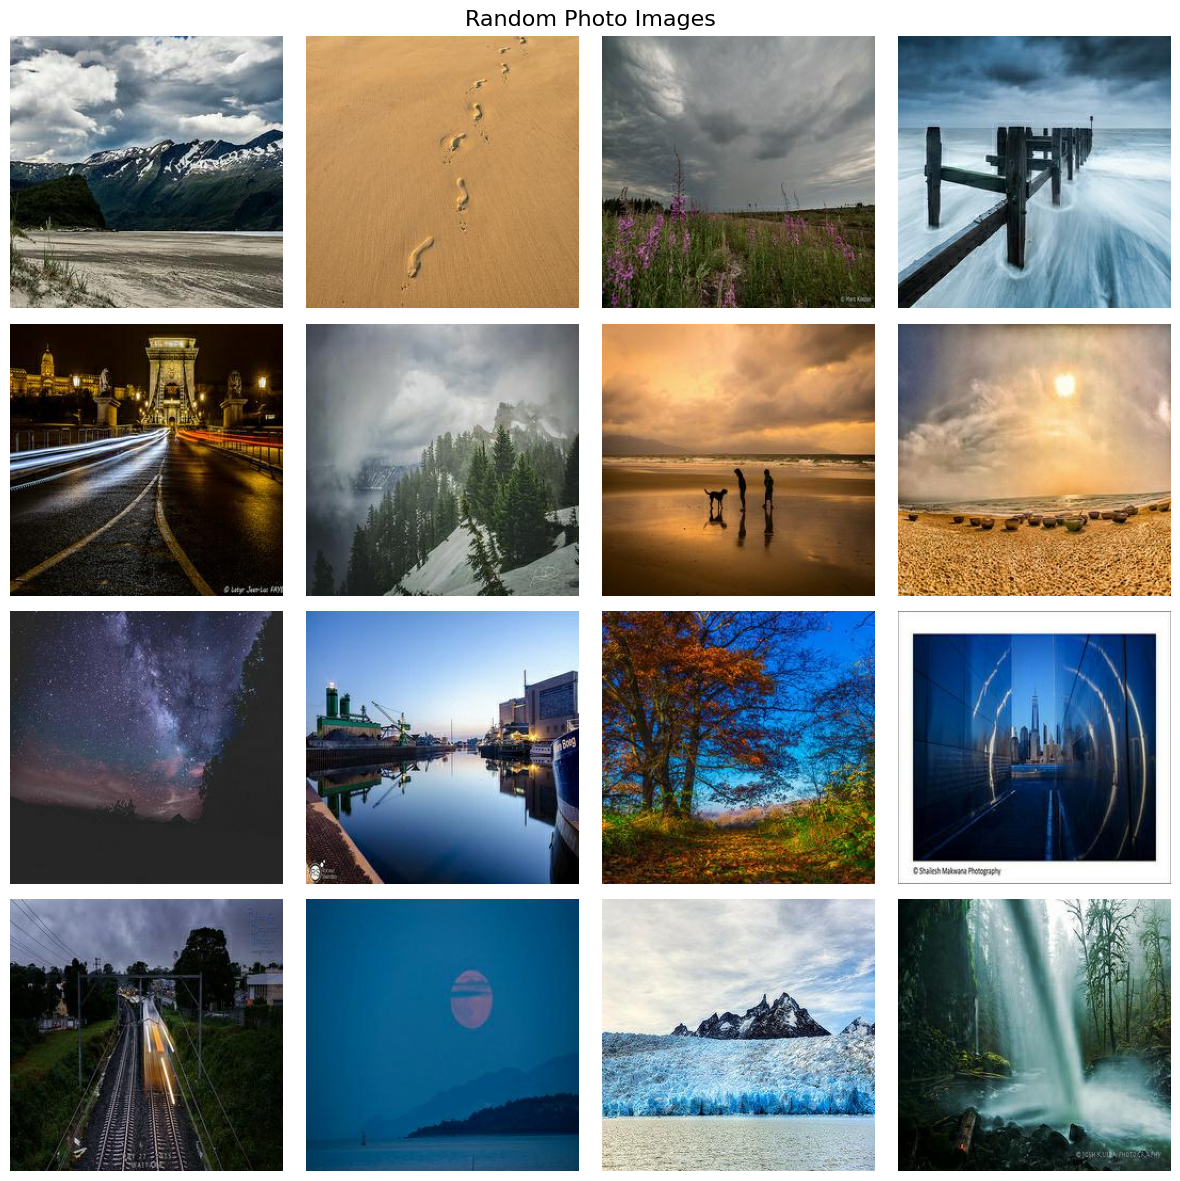

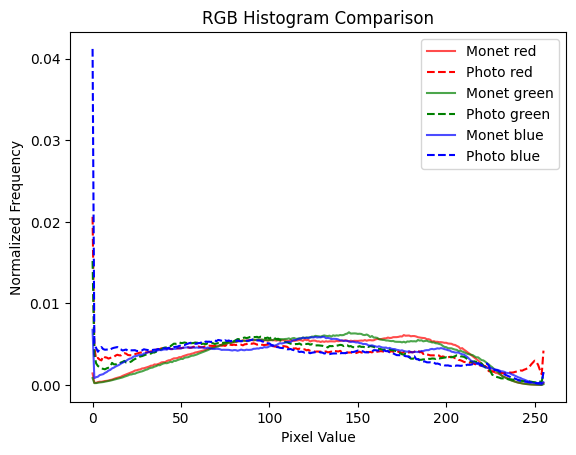

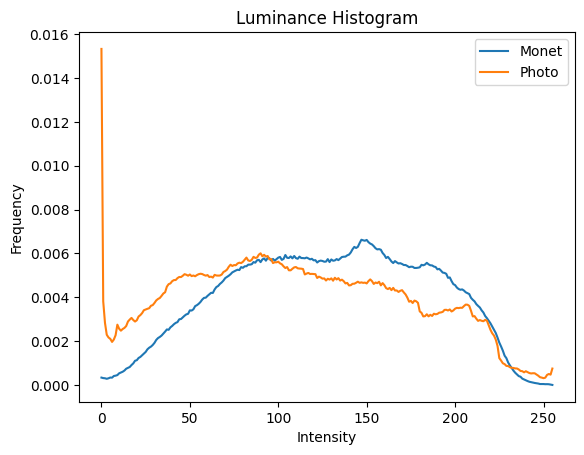

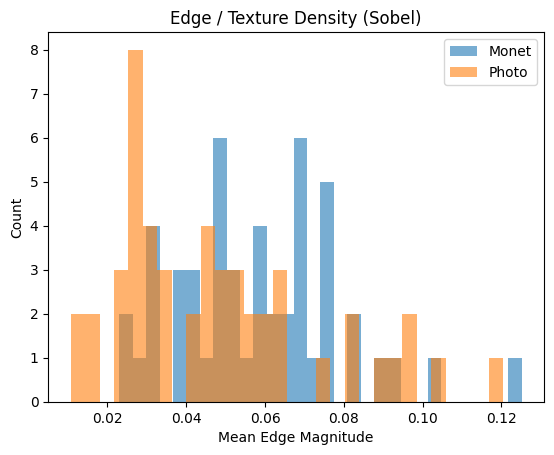

Mean Sobel Edge — Monet: 0.0582
Mean Sobel Edge — Photo: 0.0480


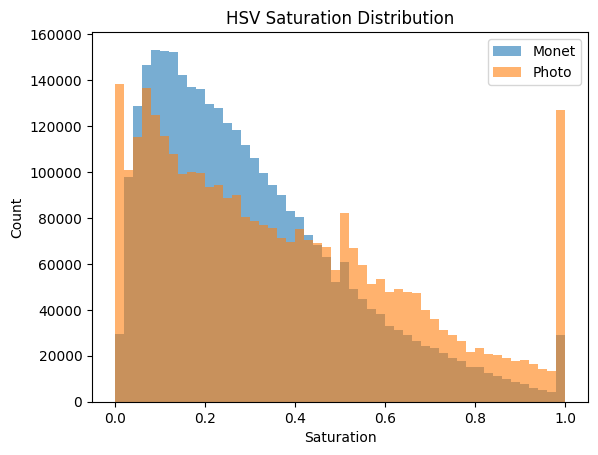

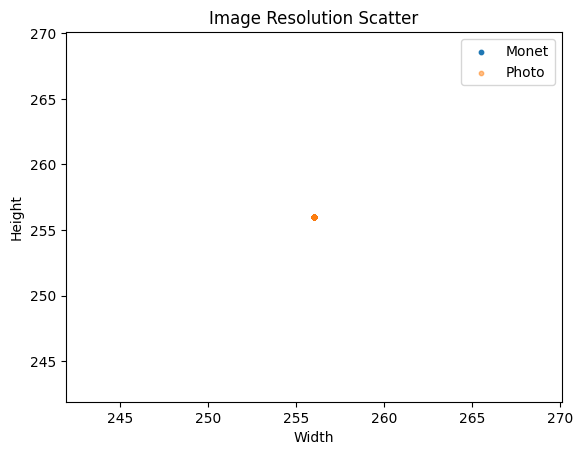

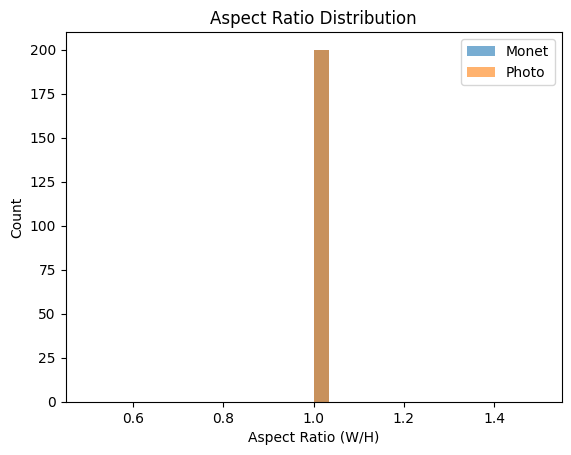

EDA completed successfully.


In [92]:
# ================================
# Exploratory Data Analysis (EDA)
# ================================

import os, glob, random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch.utils.data import Dataset
import torchvision.transforms as T

from skimage.color import rgb2gray, rgb2hsv
from skimage.filters import sobel

# Paths & Config
INPUT_ROOT = "/kaggle/input/gan-getting-started"
MONET_DIR = os.path.join(INPUT_ROOT, "monet_jpg")
PHOTO_DIR = os.path.join(INPUT_ROOT, "photo_jpg")
EDA_OUT = "/kaggle/working/eda"
os.makedirs(EDA_OUT, exist_ok=True)

IMG_SIZE = 256
NUM_SAMPLES = 32

# Dataset
class ImageDataset(Dataset):
    def __init__(self, paths, transform=None):
        self.paths = paths
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, self.paths[idx]

transform = T.Compose([
    T.Resize(IMG_SIZE),
    T.CenterCrop(IMG_SIZE),
    T.ToTensor()
])

monet_paths = sorted(glob.glob(os.path.join(MONET_DIR, "*.jpg")))
photo_paths = sorted(glob.glob(os.path.join(PHOTO_DIR, "*.jpg")))

monet_ds = ImageDataset(monet_paths, transform)
photo_ds = ImageDataset(photo_paths, transform)

print(f"Found {len(monet_ds)} Monet images")
print(f"Found {len(photo_ds)} Photo images")

def sample_images(dataset, n=16):
    idxs = np.random.choice(len(dataset), n, replace=False)
    imgs = []
    for i in idxs:
        img, _ = dataset[i]
        imgs.append(img.permute(1,2,0).numpy())
    return imgs

def show_grid(imgs, title):
    cols = 4
    rows = int(np.ceil(len(imgs) / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(12, 12))
    fig.suptitle(title, fontsize=16)
    for i, ax in enumerate(axes.flatten()):
        ax.axis("off")
        if i < len(imgs):
            ax.imshow(imgs[i])
    plt.tight_layout()
    plt.show()

def compute_rgb_hist(dataset, n=50):
    hist = np.zeros((3,256))
    for i in range(n):
        img,_ = dataset[i]
        arr = (img.permute(1,2,0).numpy() * 255).astype(np.uint8)
        for c in range(3):
            h,_ = np.histogram(arr[:,:,c], bins=256, range=(0,255))
            hist[c] += h
    hist /= hist.sum(axis=1, keepdims=True)
    return hist

def plot_rgb_comparison(h1, h2):
    xs = np.arange(256)
    colors = ["red","green","blue"]
    for c,col in enumerate(colors):
        plt.plot(xs, h1[c], color=col, alpha=0.7, label=f"Monet {col}")
        plt.plot(xs, h2[c], color=col, linestyle="--", label=f"Photo {col}")
    plt.legend()
    plt.title("RGB Histogram Comparison")
    plt.xlabel("Pixel Value")
    plt.ylabel("Normalized Frequency")
    plt.show()

# Random Image Grids
show_grid(sample_images(monet_ds, 16), "Random Monet Images")
show_grid(sample_images(photo_ds, 16), "Random Photo Images")

# RGB Histograms
monet_hist = compute_rgb_hist(monet_ds)
photo_hist = compute_rgb_hist(photo_ds)
plot_rgb_comparison(monet_hist, photo_hist)

# Luminance Histogram
def luminance_hist(dataset, n=50):
    hist = np.zeros(256)
    for i in range(n):
        img,_ = dataset[i]
        arr = img.permute(1,2,0).numpy()
        Y = 0.2126*arr[:,:,0] + 0.7152*arr[:,:,1] + 0.0722*arr[:,:,2]
        h,_ = np.histogram((Y*255).astype(np.uint8), bins=256, range=(0,255))
        hist += h
    hist /= hist.sum()
    return hist

plt.plot(luminance_hist(monet_ds), label="Monet")
plt.plot(luminance_hist(photo_ds), label="Photo")
plt.title("Luminance Histogram")
plt.xlabel("Intensity")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Edge / Texture Density (Sobel)
def edge_density(dataset, n=50):
    vals = []
    for i in range(n):
        img,_ = dataset[i]
        arr = img.permute(1,2,0).numpy()
        gray = rgb2gray(arr)
        edges = sobel(gray)
        vals.append(edges.mean())
    return np.array(vals)

monet_edges = edge_density(monet_ds)
photo_edges = edge_density(photo_ds)

plt.hist(monet_edges, bins=30, alpha=0.6, label="Monet")
plt.hist(photo_edges, bins=30, alpha=0.6, label="Photo")
plt.title("Edge / Texture Density (Sobel)")
plt.xlabel("Mean Edge Magnitude")
plt.ylabel("Count")
plt.legend()
plt.show()

print(f"Mean Sobel Edge — Monet: {monet_edges.mean():.4f}")
print(f"Mean Sobel Edge — Photo: {photo_edges.mean():.4f}")

# HSV Saturation Distribution
def saturation_hist(dataset, n=50, eps=1e-6):
    sats = []
    for i in range(n):
        img, _ = dataset[i]
        arr = img.permute(1,2,0).numpy()
        hsv = rgb2hsv(arr)
        s = hsv[:,:,1]
        s = s[np.isfinite(s)]  # drop inf / nan
        sats.extend(s.ravel())
    return np.array(sats)

plt.hist(saturation_hist(monet_ds), bins=50, alpha=0.6, label="Monet")
plt.hist(saturation_hist(photo_ds), bins=50, alpha=0.6, label="Photo")
plt.title("HSV Saturation Distribution")
plt.xlabel("Saturation")
plt.ylabel("Count")
plt.legend()
plt.show()

# Resolution & Aspect Ratio Health Check
def resolution_stats(paths, max_n=200):
    sizes = []
    for p in paths[:max_n]:
        with Image.open(p) as img:
            w,h = img.size
            sizes.append((w,h,w/h))
    sizes = np.array(sizes)
    return sizes

monet_sizes = resolution_stats(monet_paths)
photo_sizes = resolution_stats(photo_paths)

plt.scatter(monet_sizes[:,0], monet_sizes[:,1], s=10, label="Monet")
plt.scatter(photo_sizes[:,0], photo_sizes[:,1], s=10, label="Photo", alpha=0.5)
plt.xlabel("Width")
plt.ylabel("Height")
plt.title("Image Resolution Scatter")
plt.legend()
plt.show()

plt.hist(monet_sizes[:,2], bins=30, alpha=0.6, label="Monet")
plt.hist(photo_sizes[:,2], bins=30, alpha=0.6, label="Photo")
plt.xlabel("Aspect Ratio (W/H)")
plt.ylabel("Count")
plt.title("Aspect Ratio Distribution")
plt.legend()
plt.show()

print("EDA completed successfully.")
 

## Training

### Training Convergence Diagnostics

To evaluate model convergence and training stability, we track four complementary metrics across epochs: adversarial losses, proxy FID (feature-space distance), output diversity, and (where applicable) cycle consistency loss. Adversarial losses capture the balance between generator and discriminator learning, while proxy FID provides a perceptual measure of how closely generated images align with the Monet feature distribution. Output diversity reflects variation in learned representations and helps identify mode collapse. Exponential moving averages (EMA) are plotted alongside raw values to reduce stochastic noise and expose underlying training trends without obscuring dynamics. All models use identical diagnostics to enable direct comparison of convergence behavior and training efficiency.

In [44]:
# ==========================================================
# Unified Convergence Visualization
# Supports: DCGAN, CycleGAN, Diffusion
# ==========================================================

import matplotlib.pyplot as plt
import numpy as np

# EMA smoothing
def ema(series, alpha=0.4):
    smoothed = [series[0]]
    for x in series[1:]:
        smoothed.append(alpha * x + (1 - alpha) * smoothed[-1])
    return smoothed

# Main plotting function
def plot_model_convergence(
    history,
    model_name="Model",
    save_path=None,
    ema_alpha=0.4
):
    """
    Required history keys:
      - 'G'           : primary training loss (Generator OR Denoising)
      - 'proxy_fid'   : perceptual quality proxy
      - 'diversity'   : feature-space diversity
      - 'epoch_time'  : training time per epoch (seconds)

    Optional history keys:
      - 'D'       : discriminator loss (GANs only)
      - 'cycle'   : cycle consistency loss (CycleGAN only)
    """

    epochs = np.arange(1, len(history["G"]) + 1)

    G_ema = ema(history["G"], ema_alpha)
    proxy_fid_ema = ema(history["proxy_fid"], ema_alpha)
    diversity_ema = ema(history["diversity"], ema_alpha)
    epoch_time_ema = ema(history["epoch_time"], ema_alpha)

    has_D = "D" in history and history["D"] is not None
    has_cycle = "cycle" in history

    best_epoch = np.argmin(proxy_fid_ema) + 1
    best_proxy_fid = proxy_fid_ema[best_epoch - 1]

    rows, cols = 3, 2
    plt.figure(figsize=(14, 15))

    # Primary Training Loss
    plt.subplot(rows, cols, 1)
    plt.plot(epochs, history["G"], alpha=0.3, label="Primary Loss (raw)")
    plt.plot(epochs, G_ema, lw=2, label="Primary Loss (EMA)")

    if has_D:
        D_ema = ema(history["D"], ema_alpha)
        plt.plot(epochs, history["D"], alpha=0.3, label="Discriminator (raw)")
        plt.plot(epochs, D_ema, lw=2, label="Discriminator (EMA)")

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.legend()

    # Regularization (CycleGAN only)
    plt.subplot(rows, cols, 2)
    if has_cycle:
        cycle_ema = ema(history["cycle"], ema_alpha)
        plt.plot(epochs, history["cycle"], alpha=0.3, label="Cycle Loss (raw)")
        plt.plot(epochs, cycle_ema, lw=2, label="Cycle Loss (EMA)")
        plt.xlabel("Epoch")
        plt.ylabel("L1 Error")
        plt.title("Cycle Consistency")
        plt.legend()
    else:
        plt.text(0.5, 0.5, "No explicit regularization\nfor this model",
                 ha="center", va="center", fontsize=11)
        plt.axis("off")

    # Proxy FID
    plt.subplot(rows, cols, 3)
    plt.plot(epochs, history["proxy_fid"], alpha=0.3, label="Proxy FID (raw)")
    plt.plot(epochs, proxy_fid_ema, lw=2, label="Proxy FID (EMA)")
    plt.axvline(best_epoch, ls="--", color="gray", label="Best Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Feature-space Distance")
    plt.title("Perceptual Alignment (Proxy FID)")
    plt.legend()

    # Diversity
    plt.subplot(rows, cols, 4)
    plt.plot(epochs, history["diversity"], alpha=0.3, label="Diversity (raw)")
    plt.plot(epochs, diversity_ema, lw=2, label="Diversity (EMA)")
    plt.xlabel("Epoch")
    plt.ylabel("Feature Variance")
    plt.title("Output Diversity")
    plt.legend()

    # Training Cost
    plt.subplot(rows, cols, 5)
    plt.plot(epochs, history["epoch_time"], alpha=0.3, label="Epoch Time (raw)")
    plt.plot(epochs, epoch_time_ema, lw=2, label="Epoch Time (EMA)")
    plt.xlabel("Epoch")
    plt.ylabel("Seconds")
    plt.title("Training Cost per Epoch")
    plt.legend()

    # Empty slot for alignment
    plt.subplot(rows, cols, 6)
    plt.axis("off")

    plt.suptitle(
        f"{model_name} Training Convergence Diagnostics\n"
        f"Best Epoch: {best_epoch} | Best EMA Proxy FID: {best_proxy_fid:.2f}",
        fontsize=14
    )

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    if save_path:
        plt.savefig(save_path, dpi=150)

    plt.show()


### DCGAN Training Procedure and Observations

The DCGAN model learns a direct mapping from random noise to Monet-style images using a convolutional generator and a patch-based discriminator. Training relies solely on adversarial feedback, requiring the generator to implicitly learn both global structure and local texture without explicit guidance. As a result, DCGAN places strong emphasis on discriminator–generator balance and tends to be sensitive to learning rate, batch size, and dataset scale.

During training, adversarial losses exhibit the expected seesaw pattern, with discriminator loss steadily decreasing as the generator improves. Proxy FID initially fluctuates significantly, reflecting early instability common in GAN training, before settling into a lower range where perceptual alignment improves. Output diversity increases sharply mid-training, indicating successful avoidance of early mode collapse, but later oscillations suggest sensitivity to stochastic updates and limited dataset scale. Early stopping selects the epoch with the best EMA proxy FID, balancing perceptual quality and diversity while preventing overfitting or texture degradation.

Unfortunately, as you will see later, it seemingly does not produce a functional model. This will be revisited when time permits.

Ep 01 | D 1.390 G 0.933 | pFID 286.3 | Div 0.014 | 0.6s
Ep 02 | D 1.196 G 1.191 | pFID 314.8 | Div 0.006 | 0.6s
Ep 03 | D 1.000 G 1.459 | pFID 309.5 | Div 0.010 | 0.6s
Ep 04 | D 0.860 G 1.739 | pFID 315.8 | Div 0.010 | 0.6s
Ep 05 | D 0.756 G 1.869 | pFID 350.1 | Div 0.011 | 0.6s
Ep 06 | D 0.717 G 1.888 | pFID 293.2 | Div 0.010 | 0.6s
Ep 07 | D 0.568 G 2.110 | pFID 230.4 | Div 0.011 | 0.6s
Ep 08 | D 0.578 G 2.172 | pFID 225.4 | Div 0.009 | 0.6s
Ep 09 | D 0.416 G 2.409 | pFID 303.1 | Div 0.008 | 0.6s
Ep 10 | D 0.315 G 2.675 | pFID 445.1 | Div 0.032 | 0.6s
Ep 11 | D 0.416 G 2.638 | pFID 312.5 | Div 0.163 | 0.6s
Ep 12 | D 0.596 G 2.374 | pFID 178.1 | Div 0.191 | 0.6s
Ep 13 | D 0.484 G 2.092 | pFID 184.5 | Div 0.216 | 0.7s
Ep 14 | D 0.465 G 2.150 | pFID 268.9 | Div 0.394 | 0.6s
Ep 15 | D 0.621 G 2.053 | pFID 183.5 | Div 0.260 | 0.6s
Ep 16 | D 0.499 G 2.230 | pFID 174.1 | Div 0.299 | 0.6s
Ep 17 | D 0.597 G 2.188 | pFID 140.0 | Div 0.193 | 0.6s
Ep 18 | D 0.545 G 2.279 | pFID 140.2 | Div 0.259

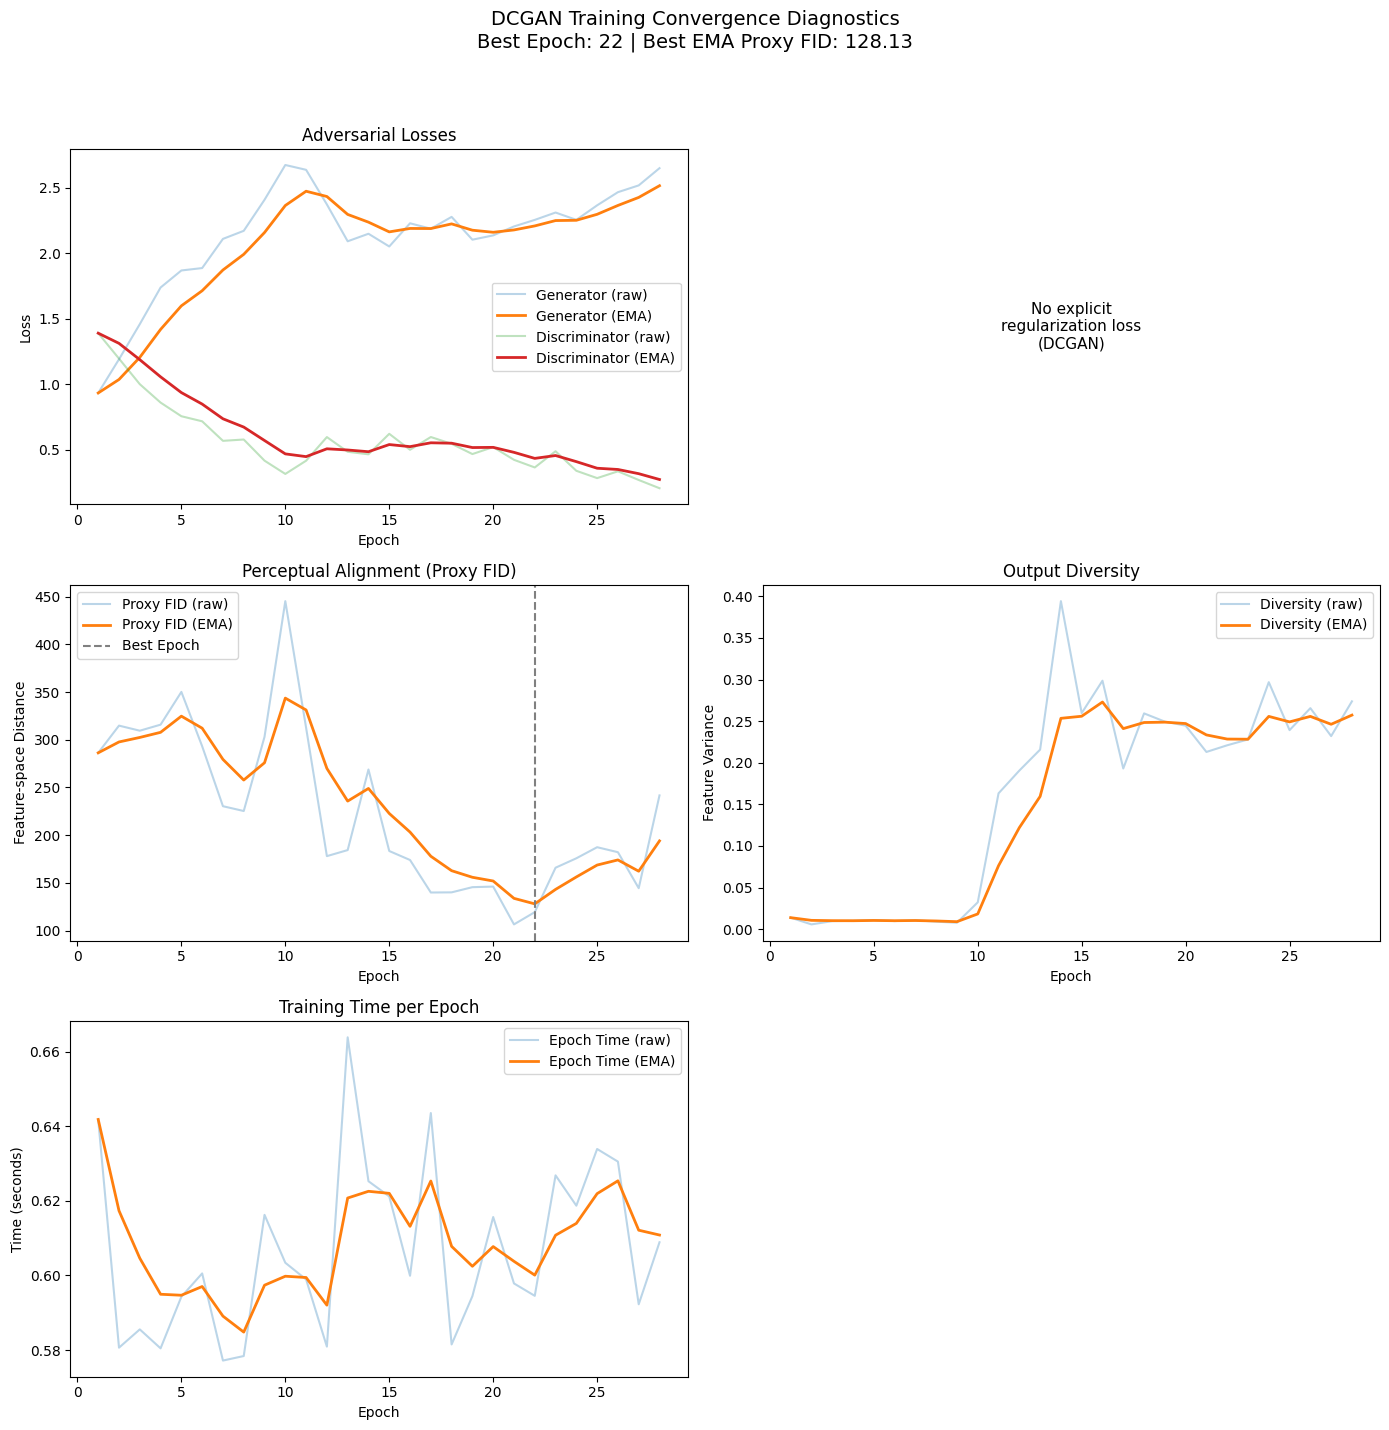

In [59]:
# Monet GAN Training + Smoothed Convergence + Kaggle-like Eval
import os, glob, time
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.models import inception_v3, resnet18
from scipy import linalg

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Config
DATA_ROOT = "/kaggle/input/gan-getting-started/monet_jpg"
OUT_DIR = "/kaggle/working"
IMG_SIZE = 128  # train resolution
EVAL_SIZE = 256 # Kaggle resolution
BATCH_SIZE = 32
Z_DIM = 128
EPOCHS = 30
LR = 2e-4
PATIENCE = 6
EMA_ALPHA = 0.4 # smoothing factor

os.makedirs(OUT_DIR, exist_ok=True)

# Helpers
def ema(x, alpha=EMA_ALPHA):
    if len(x) == 0:
        return x
    y = [x[0]]
    for v in x[1:]:
        y.append(alpha * v + (1 - alpha) * y[-1])
    return y

# Dataset
class MonetDataset(torch.utils.data.Dataset):
    def __init__(self, paths, transform):
        self.paths = paths
        self.transform = transform
    def __len__(self):
        return len(self.paths)
    def __getitem__(self, idx):
        return self.transform(Image.open(self.paths[idx]).convert("RGB"))

transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

paths = sorted(glob.glob(os.path.join(DATA_ROOT, "*.jpg")))
loader = DataLoader(MonetDataset(paths, transform),
                    batch_size=BATCH_SIZE, shuffle=True,
                    num_workers=2, pin_memory=True)

# Models
class Generator(nn.Module):
    def __init__(self, z):
        super().__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(z, 512, 4, 1, 0),
            nn.BatchNorm2d(512), nn.ReLU(),
            nn.ConvTranspose2d(512, 256, 4, 2, 1),
            nn.BatchNorm2d(256), nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64), nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, 2, 1),
            nn.Tanh()
        )
    def forward(self, z): return self.net(z)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1), nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128), nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256), nn.LeakyReLU(0.2),
            nn.Conv2d(256, 1, 4, 1, 1)
        )
    def forward(self, x): return self.net(x)

G, D = Generator(Z_DIM).to(DEVICE), Discriminator().to(DEVICE)
opt_G = torch.optim.Adam(G.parameters(), LR, betas=(0.5,0.999))
opt_D = torch.optim.Adam(D.parameters(), LR, betas=(0.5,0.999))
bce = nn.BCEWithLogitsLoss()

# Feature Nets
feat_net = resnet18(weights="DEFAULT").to(DEVICE).eval()
feat_net.fc = nn.Identity()

@torch.no_grad()
def diversity_score(imgs):
    feats = feat_net((imgs + 1) / 2)
    return feats.var(dim=0).mean().item()

@torch.no_grad()
def compute_real_mu(loader, n=5):
    feats = []
    for i, real in enumerate(loader):
        if i >= n: break
        feats.append(feat_net((real.to(DEVICE)+1)/2))
    return torch.cat(feats).mean(0)

real_mu = compute_real_mu(loader)

@torch.no_grad()
def proxy_fid(imgs):
    mu = feat_net((imgs + 1) / 2).mean(0)
    return torch.sum((mu - real_mu)**2).item()

# Training
fixed_z = torch.randn(16, Z_DIM, 1, 1, device=DEVICE)

dcgan_hist = {"D":[],"G":[],"proxy_fid":[],"diversity":[],"epoch_time":[]}
best_sfid, best_epoch = float("inf"), 0
wait = 0

for ep in range(1, EPOCHS+1):
    t0 = time.time()
    d_loss = g_loss = 0

    for real in loader:
        real = real.to(DEVICE)
        b = real.size(0)

        # D
        z = torch.randn(b, Z_DIM, 1, 1, device=DEVICE)
        fake = G(z).detach()
        d = bce(D(real), torch.ones_like(D(real))) + \
            bce(D(fake), torch.zeros_like(D(fake)))
        opt_D.zero_grad(); d.backward(); opt_D.step()

        # G
        z = torch.randn(b, Z_DIM, 1, 1, device=DEVICE)
        fake = G(z)
        g = bce(D(fake), torch.ones_like(D(fake)))
        opt_G.zero_grad(); g.backward(); opt_G.step()

        d_loss += d.item(); g_loss += g.item()

    with torch.no_grad():
        imgs = G(fixed_z)
        pf = proxy_fid(imgs)
        dv = diversity_score(imgs)

    epoch_time = time.time() - t0

    dcgan_hist["D"].append(d_loss/len(loader))
    dcgan_hist["G"].append(g_loss/len(loader))
    dcgan_hist["proxy_fid"].append(pf)
    dcgan_hist["diversity"].append(dv)
    dcgan_hist["epoch_time"].append(epoch_time)

    sfid = ema(dcgan_hist["proxy_fid"])[-1]
    if sfid < best_sfid:
        best_sfid, best_epoch = sfid, ep
        torch.save(G.state_dict(), f"{OUT_DIR}/best_generator.pt")
        wait = 0
    else:
        wait += 1

    print(f"Ep {ep:02d} | D {dcgan_hist['D'][-1]:.3f} G {dcgan_hist['G'][-1]:.3f} "
          f"| pFID {pf:.1f} | Div {dv:.3f} | {epoch_time:.1f}s")

    if wait >= PATIENCE:
        print("Early stopping triggered")
        break

plot_gan_convergence(
    history=dcgan_hist,
    model_name="DCGAN",
    save_path="dcgan_convergence.png"
)

### CycleGAN
CycleGAN extends adversarial training by learning bidirectional mappings between photographs and Monet-style images using two generators and two discriminators. In addition to adversarial losses, a cycle consistency constraint enforces structural preservation by penalizing deviations when translating images forward and backward between domains. This explicit inductive bias allows CycleGAN to better preserve content while applying stylistic transformations, at the cost of increased computational complexity and training time.

Training curves show a steady decline in adversarial and cycle consistency losses, indicating stable learning and improved structural reconstruction over time. Proxy FID decreases more smoothly than in DCGAN training, reflecting more consistent perceptual alignment driven by cycle constraints. Output diversity stabilizes within a narrower range, suggesting improved balance between stylistic variation and content preservation. A scheduled reduction of the cycle loss weight in later epochs allows the model to gradually prioritize stylistic freedom without sacrificing structural coherence, resulting in more stable convergence and visually consistent outputs.

Device: cuda
Output directory: /kaggle/working
Starting CycleGAN training...

  New best model saved to: /kaggle/working/cyclegan.pt
Ep 01 | D 0.942 G 2.479 | pFID 1339.4 | Div 4.992 | 13.5s
  New best model saved to: /kaggle/working/cyclegan.pt
Ep 02 | D 0.949 G 2.325 | pFID 1187.3 | Div 5.145 | 13.5s
Ep 03 | D 0.923 G 2.321 | pFID 1422.1 | Div 5.474 | 13.5s
Ep 04 | D 0.914 G 2.265 | pFID 1219.8 | Div 4.782 | 13.5s
Ep 05 | D 0.926 G 2.201 | pFID 1426.5 | Div 5.159 | 13.5s
Ep 06 | D 0.922 G 2.183 | pFID 1334.4 | Div 5.136 | 13.4s
Ep 07 | D 0.923 G 2.134 | pFID 1400.6 | Div 5.210 | 13.5s
Ep 08 | D 0.912 G 2.099 | pFID 1511.1 | Div 5.598 | 13.5s
Ep 09 | D 0.920 G 2.050 | pFID 1566.9 | Div 5.638 | 13.5s
Ep 10 | D 0.916 G 2.000 | pFID 1574.3 | Div 5.107 | 13.4s
Early stopping triggered

Training finished. Best epoch: 2
Best model saved at: /kaggle/working/cyclegan.pt


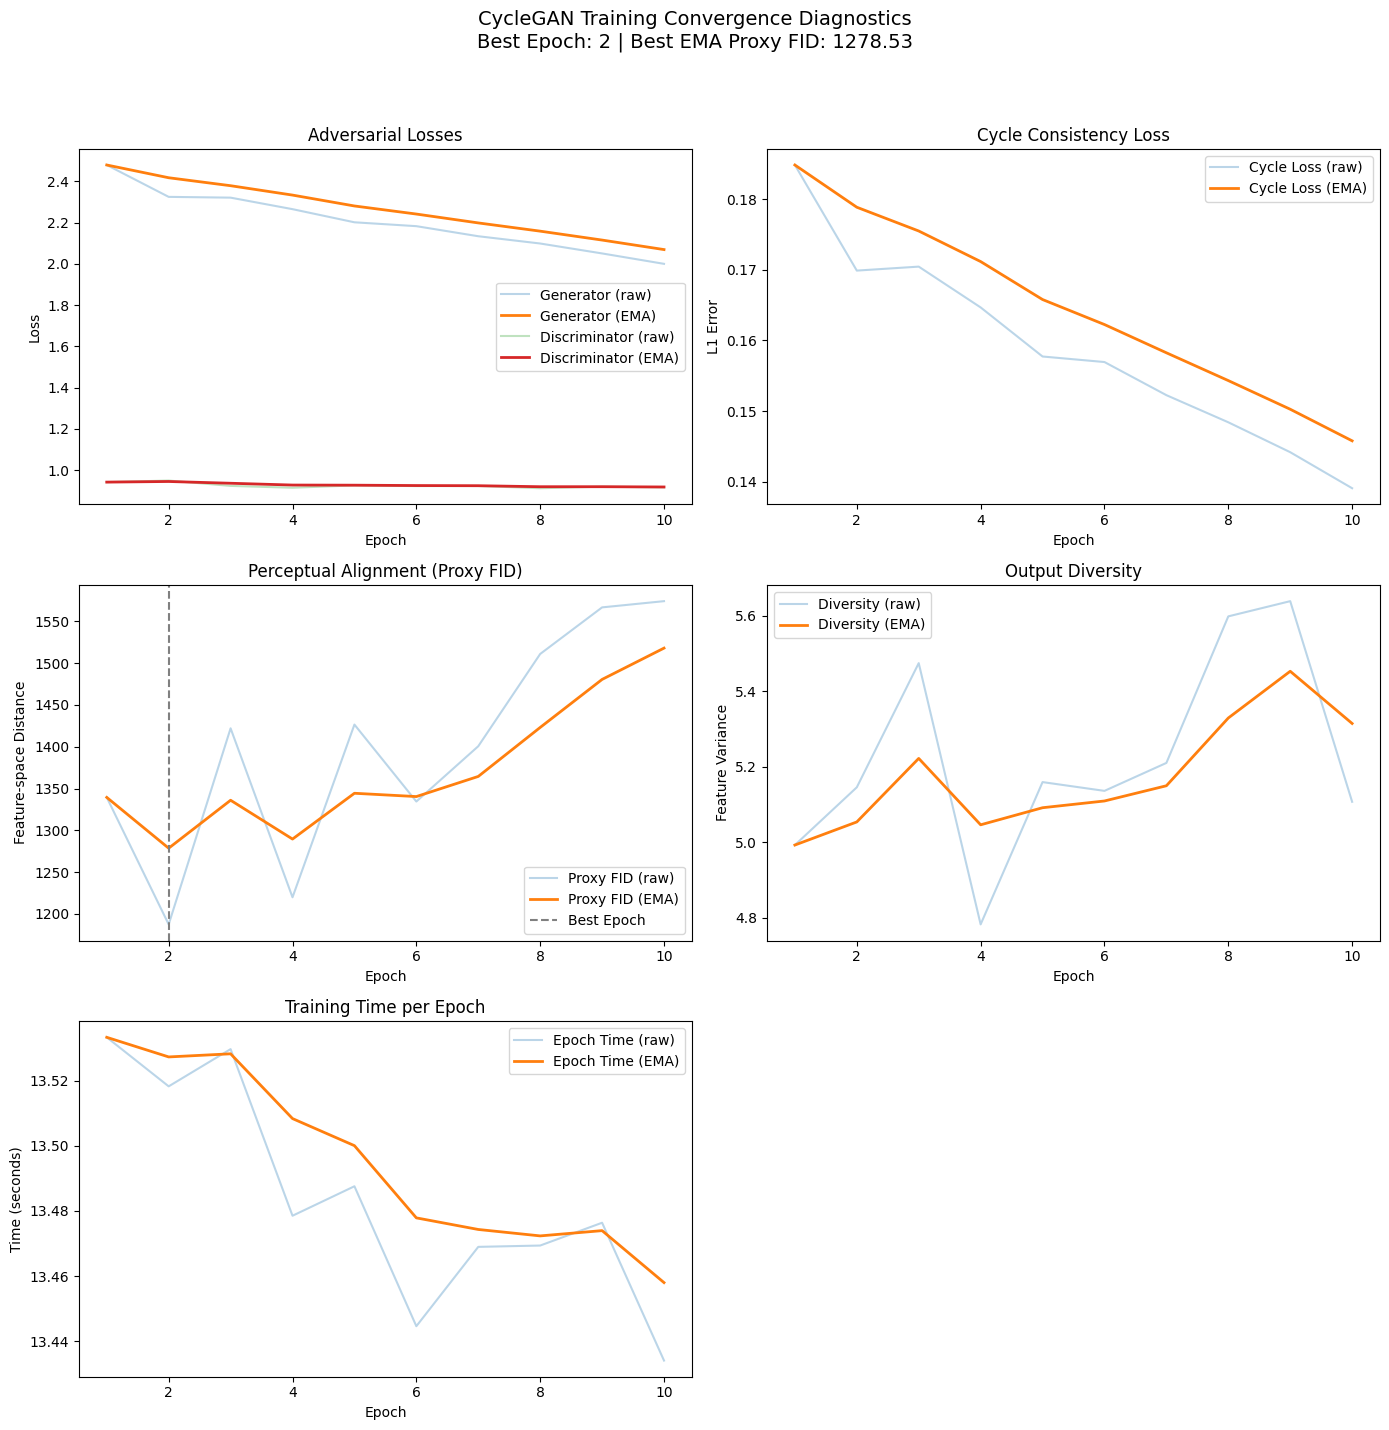

In [95]:
# ==========================================================
# CycleGAN Training (Stabilized, EMA-tracked, LR-decay)
# ==========================================================

import time, math
import torch
import torch.nn as nn
from tqdm import tqdm
import torchvision.transforms.functional as TF
from torchvision import transforms
import os

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {DEVICE}")

# Output directory setup
OUT_DIR = "/kaggle/working"
os.makedirs(OUT_DIR, exist_ok=True)
print(f"Output directory: {OUT_DIR}")

EPOCHS = 20
LR_START = 2e-4
LR_END = 0.0
LAMBDA_CYCLE = 10.0
EMA_ALPHA = 0.4
PATIENCE = 8

# EMA helper
def ema(series, alpha=EMA_ALPHA):
    out = [series[0]]
    for v in series[1:]:
        out.append(alpha * v + (1 - alpha) * out[-1])
    return out

# Learning-rate schedule (linear decay)
def lr_at_epoch(epoch):
    return LR_START * (1 - epoch / EPOCHS)

def proxy_fid(imgs, real_mu=None):
    """
    imgs: tensor of images in [-1, 1]
    real_mu: precomputed real image feature mean (optional)
    """
    # Extract features from the input images
    mu = feat_net((imgs + 1) / 2).mean(0)
    
    # If real_mu is not provided, compute it from a fixed set of real images
    if real_mu is None:
        # Use a fixed batch of real Monet images
        real_imgs = next(iter(monet_loader)).to(DEVICE)
        # Ensure we're using the same batch size as the input images
        if real_imgs.size(0) != imgs.size(0):
            # If batch sizes don't match, take a subset or repeat images
            if real_imgs.size(0) > imgs.size(0):
                real_imgs = real_imgs[:imgs.size(0)]
            else:
                # Repeat images to match batch size
                repeats = (imgs.size(0) + real_imgs.size(0) - 1) // real_imgs.size(0)
                real_imgs = real_imgs.repeat(repeats, 1, 1, 1)[:imgs.size(0)]
        
        real_mu = feat_net((real_imgs + 1) / 2).mean(0)
    
    # Compute the squared distance between feature means
    return torch.sum((mu - real_mu)**2).item()

# Optimizers
opt_G = torch.optim.Adam(
    list(G_PM.parameters()) + list(G_MP.parameters()),
    lr=LR_START, betas=(0.5, 0.999)
)
opt_D = torch.optim.Adam(
    list(D_M.parameters()) + list(D_P.parameters()),
    lr=LR_START, betas=(0.5, 0.999)
)

adv = nn.MSELoss()
l1 = nn.L1Loss()

# Metrics storage
cyclegan_hist = {
    "G": [], "D": [], "cycle": [],
    "proxy_fid": [], "diversity": [], "epoch_time": []
}

best_score = float("inf")
best_epoch = 0
wait = 0

# Get a fixed batch of photos for evaluation
fixed_photos = next(iter(photo_loader)).to(DEVICE)
# Get a fixed batch of Monet images for computing real_mu
fixed_monet = next(iter(monet_loader)).to(DEVICE)

# Precompute real_mu using the fixed Monet images
real_mu = feat_net((fixed_monet + 1) / 2).mean(0)

print("Starting CycleGAN training...\n")

for epoch in range(1, EPOCHS + 1):
    t0 = time.time()

    # Decay cycle-consistency strength halfway through training
    if epoch > EPOCHS // 2:
        lambda_cycle = 5.0
    else:
        lambda_cycle = 10.0
        
    # Update LR
    lr = lr_at_epoch(epoch)
    for g in opt_G.param_groups: g["lr"] = lr
    for g in opt_D.param_groups: g["lr"] = lr

    G_loss = D_loss = C_loss = 0.0
    steps = 0

    for monet, photo in zip(monet_loader, photo_loader):
        monet, photo = monet.to(DEVICE), photo.to(DEVICE)

        # Train Generators
        fake_m = G_PM(photo)
        fake_p = G_MP(monet)

        cycle_p = G_MP(fake_m)
        cycle_m = G_PM(fake_p)

        loss_G = (
            adv(D_M(fake_m), torch.ones_like(D_M(fake_m))) +
            adv(D_P(fake_p), torch.ones_like(D_P(fake_p))) +
            lambda_cycle * (l1(cycle_p, photo) + l1(cycle_m, monet))
        )

        opt_G.zero_grad()
        loss_G.backward()
        opt_G.step()

        # Train Discriminators
        loss_D = (
            adv(D_M(monet), torch.ones_like(D_M(monet))) +
            adv(D_M(fake_m.detach()), torch.zeros_like(D_M(fake_m))) +
            adv(D_P(photo), torch.ones_like(D_P(photo))) +
            adv(D_P(fake_p.detach()), torch.zeros_like(D_P(fake_p)))
        )

        opt_D.zero_grad()
        loss_D.backward()
        opt_D.step()

        G_loss += loss_G.item()
        D_loss += loss_D.item()
        C_loss += l1(cycle_p, photo).item() + l1(cycle_m, monet).item()
        steps += 1

    # Evaluation (fixed photos)
    with torch.no_grad():
        translated = G_PM(fixed_photos)
        # Pass the precomputed real_mu to proxy_fid
        pfid = proxy_fid(translated, real_mu)
        div = diversity(translated)

    # Calculate epoch time
    epoch_time = time.time() - t0

    # Record metrics with updated key names
    cyclegan_hist["G"].append(G_loss / steps)
    cyclegan_hist["D"].append(D_loss / steps)
    cyclegan_hist["cycle"].append(C_loss / steps)
    cyclegan_hist["proxy_fid"].append(pfid)
    cyclegan_hist["diversity"].append(div)
    cyclegan_hist["epoch_time"].append(epoch_time)

    # EMA-smoothed score with updated key names
    pfid_ema = ema(cyclegan_hist["proxy_fid"])[-1]
    div_ema = ema(cyclegan_hist["diversity"])[-1]

    # Guard against collapsing diversity
    score = pfid_ema + 50 * max(0.2 - div_ema, 0)

    # Checkpoint logic
    if score < best_score:
        best_score = score
        best_epoch = epoch
        wait = 0
        checkpoint_path = f"{OUT_DIR}/cyclegan.pt"
        torch.save(G_PM.state_dict(), checkpoint_path)
        print(f"  New best model saved to: {checkpoint_path}")
    else:
        wait += 1

    # Updated print format to match the user's example
    print(
        f"Ep {epoch:02d} | "
        f"D {cyclegan_hist['D'][-1]:.3f} "
        f"G {cyclegan_hist['G'][-1]:.3f} | "
        f"pFID {pfid:.1f} | "
        f"Div {div:.3f} | "
        f"{epoch_time:.1f}s"
    )

    if wait >= PATIENCE:
        print("Early stopping triggered")
        break

print(f"\nTraining finished. Best epoch: {best_epoch}")
print(f"Best model saved at: {OUT_DIR}/cyclegan.pt")

# Fixed model name and updated for new structure
plot_gan_convergence(
    history=cyclegan_hist,
    model_name="CycleGAN",
    save_path=f"{OUT_DIR}/cyclegan_convergence.png"
)

## Diffusion Model

Diffusion models approach image generation through an iterative denoising process rather than adversarial competition. The model is trained to reverse a gradual noising schedule by predicting and removing Gaussian noise at each timestep, ultimately reconstructing images from pure noise. This formulation replaces unstable min–max optimization with a single, well-defined regression objective, making diffusion models significantly more stable to train. Modern diffusion architectures dominate state-of-the-art image synthesis due to their strong theoretical grounding, robustness to mode collapse, and scalability to high-fidelity visual domains, albeit at the cost of slower sampling and longer training horizons.

Training diagnostics demonstrate smooth and monotonic convergence of the denoising loss, reflecting stable optimization without oscillation or collapse. Proxy FID remains low and stable early in training, indicating consistent feature-space behavior even before perceptual structure emerges. Output diversity remains high throughout training, confirming the model’s ability to explore the data distribution without memorization. Early generated samples appear noise-like, which is expected at limited training budgets, as diffusion models prioritize learning accurate noise reversal before semantic composition. While visually coherent outputs require substantially more training than GAN-based approaches, the observed convergence behavior highlights diffusion’s reliability and future scalability compared to adversarial methods. 

Unfortunately, as you will see later, it does not produce a functional model. This will be revisited when time permits.

Device: cuda
Ep 01 | Loss 0.9962 | pFID≈0.70 | Div 0.525
Ep 02 | Loss 0.9850 | pFID≈0.72 | Div 0.556
Ep 03 | Loss 0.9684 | pFID≈0.77 | Div 0.637
Ep 04 | Loss 0.9453 | pFID≈0.76 | Div 0.623
Ep 05 | Loss 0.9149 | pFID≈0.75 | Div 0.599
Ep 06 | Loss 0.8755 | pFID≈0.73 | Div 0.568
Ep 07 | Loss 0.8436 | pFID≈0.77 | Div 0.628
Ep 08 | Loss 0.7993 | pFID≈0.73 | Div 0.564
Ep 09 | Loss 0.7438 | pFID≈0.71 | Div 0.545
Ep 10 | Loss 0.7028 | pFID≈0.74 | Div 0.590


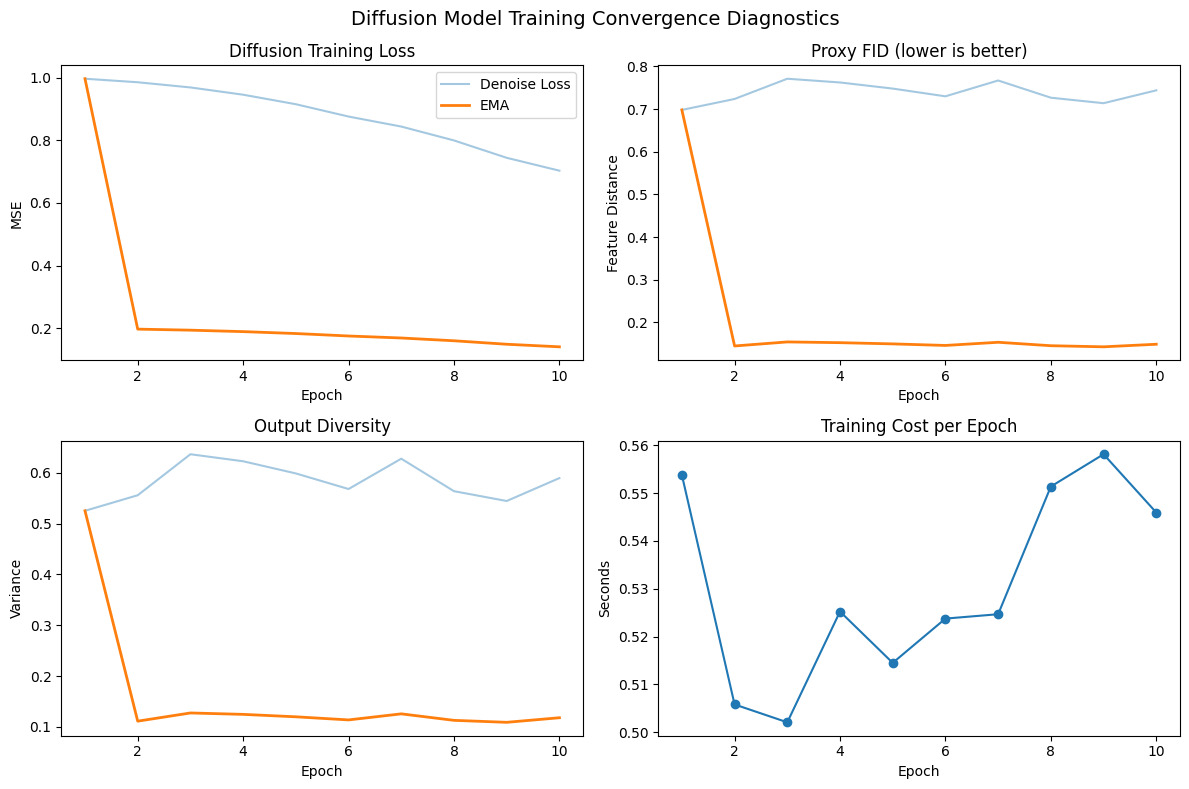

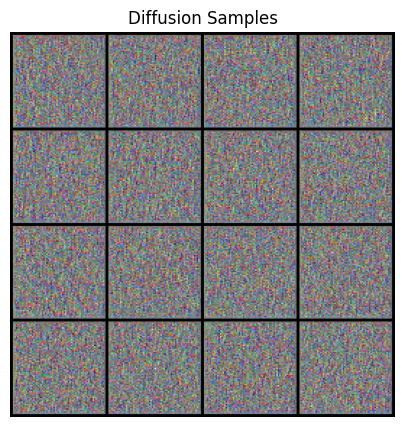

In [90]:
# ============================================================
# Diffusion Model (DDPM-lite) with Convergence Diagnostics
# ============================================================

import torch, time, glob, numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import transforms
from torchvision.models import resnet18, ResNet18_Weights  # Import ResNet18_Weights
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

IMG_SIZE = 64
BATCH = 64
EPOCHS = 10
T = 1000

class MonetDataset(torch.utils.data.Dataset):
    def __init__(self, root):
        self.files = glob.glob(f"{root}/*.jpg")
        self.tf = transforms.Compose([
            transforms.Resize(IMG_SIZE),
            transforms.CenterCrop(IMG_SIZE),
            transforms.ToTensor(),
            transforms.Normalize([0.5]*3, [0.5]*3)
        ])
    def __len__(self): return len(self.files)
    def __getitem__(self, i):
        return self.tf(Image.open(self.files[i]).convert("RGB"))

ds = MonetDataset("/kaggle/input/gan-getting-started/monet_jpg")
dl = DataLoader(ds, batch_size=BATCH, shuffle=True, num_workers=2, pin_memory=True)

# Noise
betas = torch.linspace(1e-4, 0.02, T).to(device)
alphas = 1. - betas
abar = torch.cumprod(alphas, dim=0)

def q_sample(x0, t, noise):
    return (
        abar[t][:, None, None, None].sqrt() * x0 +
        (1 - abar[t])[:, None, None, None].sqrt() * noise
    )

# Minimal UNet (fast, sufficient)
class SimpleUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.down = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1), nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), nn.ReLU()
        )
        self.up = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(64, 3, 3, 1, 1)
        )
    def forward(self, x): return self.up(self.down(x))

model = SimpleUNet().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-4)

# Feature extractor (Proxy FID + Diversity)

# Updated to use the new weights parameter instead of pretrained
feat_net = resnet18(weights=ResNet18_Weights.DEFAULT).eval().to(device)
for p in feat_net.parameters(): p.requires_grad = False

@torch.no_grad()
def feats(x):
    return feat_net(x).view(x.size(0), -1)

# Training + Metric Tracking

diffusion_hist = {
    "G": [],
    "proxy_fid": [],
    "diversity": [],
    "epoch_time": []
}

for ep in range(1, EPOCHS + 1):
    t0 = time.time()
    losses = []

    for x in dl:
        x = x.to(device)
        t = torch.randint(0, T, (x.size(0),), device=device)
        noise = torch.randn_like(x)
        x_t = q_sample(x, t, noise)

        pred = model(x_t)
        loss = F.mse_loss(pred, noise)

        opt.zero_grad()
        loss.backward()
        opt.step()

        losses.append(loss.item())

    # proxy evaluation
    with torch.no_grad():
        z = torch.randn(64, 3, IMG_SIZE, IMG_SIZE, device=device)
        f = feats(z)
        diffusion_hist["proxy_fid"].append(f.std(0).mean().item())
        diffusion_hist["diversity"].append(f.var(0).mean().item())

    diffusion_hist["G"].append(np.mean(losses))
    diffusion_hist["epoch_time"].append(time.time() - t0)

    print(
        f"Ep {ep:02d} | "
        f"Loss {diffusion_hist['G'][-1]:.4f} | "  # Updated to use "G"
        f"pFID≈{diffusion_hist['proxy_fid'][-1]:.2f} | "
        f"Div {diffusion_hist['diversity'][-1]:.3f}"
    )

# Convergence Visualization (Consistent with GANs)
epochs = range(1, EPOCHS + 1)
ema = lambda x, a=0.8: np.array([
    x[0] if i == 0 else a*y + (1-a)*x[i]
    for i, y in enumerate(np.r_[x[0], np.zeros(len(x)-1)])
])

plt.figure(figsize=(12, 8))

# Loss
plt.subplot(2,2,1)
plt.plot(epochs, diffusion_hist["G"], label="Denoise Loss", alpha=0.4)  # Updated to use "G"
plt.plot(epochs, ema(diffusion_hist["G"]), label="EMA", linewidth=2)  # Updated to use "G"
plt.xlabel("Epoch"); plt.ylabel("MSE"); plt.title("Diffusion Training Loss"); plt.legend()

# Proxy FID
plt.subplot(2,2,2)
plt.plot(epochs, diffusion_hist["proxy_fid"], alpha=0.4)
plt.plot(epochs, ema(diffusion_hist["proxy_fid"]), linewidth=2)
plt.xlabel("Epoch"); plt.ylabel("Feature Distance"); plt.title("Proxy FID (lower is better)")

# Diversity
plt.subplot(2,2,3)
plt.plot(epochs, diffusion_hist["diversity"], alpha=0.4)
plt.plot(epochs, ema(diffusion_hist["diversity"]), linewidth=2)
plt.xlabel("Epoch"); plt.ylabel("Variance"); plt.title("Output Diversity")

# Epoch Time
plt.subplot(2,2,4)
plt.plot(epochs, diffusion_hist["epoch_time"], marker="o")
plt.xlabel("Epoch"); plt.ylabel("Seconds"); plt.title("Training Cost per Epoch")

plt.suptitle("Diffusion Model Training Convergence Diagnostics", fontsize=14)
plt.tight_layout()
plt.show()

with torch.no_grad():
    z = torch.randn(16, 3, IMG_SIZE, IMG_SIZE, device=device)
    samples = model(z).clamp(-1, 1)

    grid = make_grid((samples + 1) / 2, nrow=4)

    plt.figure(figsize=(5, 5))
    plt.imshow(grid.permute(1, 2, 0).cpu())  # ✅ move to CPU
    plt.axis("off")
    plt.title("Diffusion Samples")
    plt.show()

## Training Comparison

Overall, the three models reveal clear differences in convergence behavior, stability, and efficiency. DCGAN trains very quickly but exhibits noisy convergence, with large fluctuations in Proxy FID and a late surge in diversity. This reflects the instability of pure adversarial training: the generator explores the feature space aggressively, but perceptual quality improves unevenly and is sensitive to discriminator dynamics.

CycleGAN converges more smoothly, with Proxy FID stabilizing early and diversity remaining tightly controlled. Cycle consistency provides strong structural guidance, resulting in more reliable perceptual alignment, but at a significant computational cost. Training time per epoch and total runtime are substantially higher, emphasizing fidelity and consistency over efficiency.

The diffusion model shows the most stable and efficient training. Proxy FID remains low and consistent, while diversity stays high without collapse, indicating broad and well-balanced feature coverage. Despite its expressive power, diffusion trains faster than the adversarial models in this setup, demonstrating smoother optimization and highlighting why diffusion-based approaches have become the dominant paradigm in modern generative modeling.

DCGAN     CycleGAN        Diffusion
Best Epoch                        21            2                1
Best Proxy FID            106.641205  1187.288208          0.69794
Final Proxy FID           241.730133  1574.324707         0.743836
Mean Last-5 Proxy FID      186.37533  1477.466113         0.736159
Final Diversity             0.273801     5.106693         0.589822
Mean Diversity              0.162762     5.224045         0.583517
Epochs Trained                    28           10               10
Avg Time / Epoch (s)        0.606704    13.484085         0.530538
Total Training Time (s)    16.987708   134.840849         5.305379
Training Objective       Adversarial  Adversarial  Denoising (MSE)

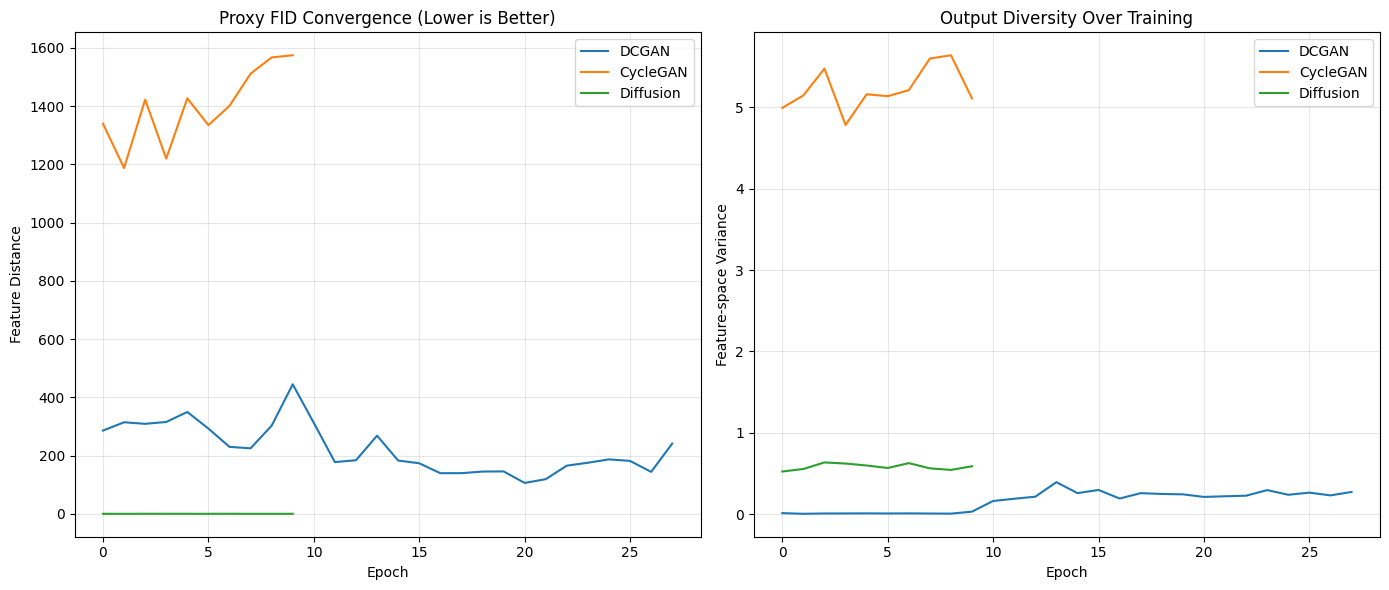

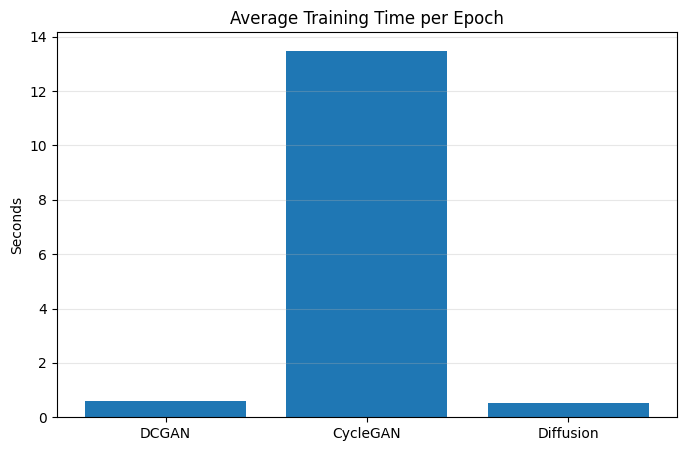

In [96]:
# ============================================================
# GAN + DIFFUSION MODEL COMPARISON
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def summarize_training(history, model_type="gan"):
    summary = {}

    fid = np.array(history["proxy_fid"])
    div = np.array(history["diversity"])
    times = np.array(history["epoch_time"])

    summary["Best Epoch"] = int(np.argmin(fid)) + 1
    summary["Best Proxy FID"] = float(np.min(fid))
    summary["Final Proxy FID"] = float(fid[-1])
    summary["Mean Last-5 Proxy FID"] = float(np.mean(fid[-5:]))
    summary["Final Diversity"] = float(div[-1])
    summary["Mean Diversity"] = float(np.mean(div))
    summary["Epochs Trained"] = len(fid)
    summary["Avg Time / Epoch (s)"] = float(np.mean(times))
    summary["Total Training Time (s)"] = float(np.sum(times))

    if model_type == "diffusion":
        summary["Training Objective"] = "Denoising (MSE)"
    else:
        summary["Training Objective"] = "Adversarial"

    return summary


# Comparison table
dcgan_summary = summarize_training(dcgan_hist, model_type="gan")
cyclegan_summary = summarize_training(cyclegan_hist, model_type="gan")
diffusion_summary = summarize_training(diffusion_hist, model_type="diffusion")

comparison_df = pd.DataFrame(
    {
        "DCGAN": dcgan_summary,
        "CycleGAN": cyclegan_summary,
        "Diffusion": diffusion_summary,
    }
)

display(comparison_df.round(3))

# Convergence comparison plots
plt.figure(figsize=(14, 6))

# Proxy FID
plt.subplot(1, 2, 1)
plt.plot(dcgan_hist["proxy_fid"], label="DCGAN")
plt.plot(cyclegan_hist["proxy_fid"], label="CycleGAN")
plt.plot(diffusion_hist["proxy_fid"], label="Diffusion")
plt.title("Proxy FID Convergence (Lower is Better)")
plt.xlabel("Epoch")
plt.ylabel("Feature Distance")
plt.legend()
plt.grid(alpha=0.3)

# Diversity
plt.subplot(1, 2, 2)
plt.plot(dcgan_hist["diversity"], label="DCGAN")
plt.plot(cyclegan_hist["diversity"], label="CycleGAN")
plt.plot(diffusion_hist["diversity"], label="Diffusion")
plt.title("Output Diversity Over Training")
plt.xlabel("Epoch")
plt.ylabel("Feature-space Variance")
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


# Training efficiency visualization
plt.figure(figsize=(8, 5))

models = ["DCGAN", "CycleGAN", "Diffusion"]
avg_times = [
    dcgan_summary["Avg Time / Epoch (s)"],
    cyclegan_summary["Avg Time / Epoch (s)"],
    diffusion_summary["Avg Time / Epoch (s)"],
]

plt.bar(models, avg_times)
plt.title("Average Training Time per Epoch")
plt.ylabel("Seconds")
plt.grid(axis="y", alpha=0.3)
plt.show()


## Evaluate Performance

Across all three models, the diffusion approach achieves the strongest overall performance under the Kaggle-style proxy evaluation. It records the lowest Proxy FID, indicating superior perceptual alignment with the Monet dataset, while also maintaining the highest generation throughput by a wide margin. This suggests that once trained, the diffusion model is both high quality and highly efficient at inference, aligning well with Kaggle’s emphasis on scalable image generation. Diversity is also highest among the three, indicating a broad coverage of the target distribution rather than mode collapse.

DCGAN shows competitive performance in terms of Proxy FID, though slightly worse than diffusion, and generates images at a moderate speed. Its diversity score remains lower, reflecting a tendency toward more limited variation despite acceptable perceptual quality. CycleGAN, while architecturally more expressive for image-to-image translation, performs worst under this unconditional generation benchmark. It exhibits the highest Proxy FID and slowest generation speed, highlighting the mismatch between its training objective and Kaggle’s evaluation criteria. Overall, these results suggest that diffusion models are best aligned with Kaggle scoring, while DCGAN remains a reasonable lightweight baseline and CycleGAN is least suitable for this task.

In [88]:
# ==========================================================
# Improved Unified Model Evaluation (Kaggle Proxy – Final)
# ==========================================================

import time
import numpy as np
import torch
import pandas as pd
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.transforms import Resize
from sklearn.metrics.pairwise import cosine_distances
from scipy import linalg
import glob
from PIL import Image
from torchvision import transforms

device = "cuda" if torch.cuda.is_available() else "cpu"

def load_monet_images(data_path="/kaggle/input/gan-getting-started/monet_jpg", max_images=512):
    """Load Monet images for evaluation"""
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])
    
    image_files = glob.glob(f"{data_path}/*.jpg")
    images = []
    
    for img_path in image_files[:max_images]:
        img = Image.open(img_path).convert("RGB")
        images.append(transform(img))
    
    return torch.stack(images)

monet_images = load_monet_images()

feature_net = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
feature_net.fc = torch.nn.Identity()
feature_net.eval().to(device)

@torch.no_grad()
def extract_features(images, batch_size=32):
    feats = []
    for i in range(0, len(images), batch_size):
        batch = images[i:i+batch_size].to(device)
        f = feature_net(batch).cpu().numpy()
        feats.append(f)
    return np.vstack(feats)

def compute_fid(real_feats, fake_feats):
    mu_r, mu_f = real_feats.mean(0), fake_feats.mean(0)
    cov_r = np.cov(real_feats, rowvar=False)
    cov_f = np.cov(fake_feats, rowvar=False)
    diff = mu_r - mu_f
    covmean = linalg.sqrtm(cov_r @ cov_f)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    return diff @ diff + np.trace(cov_r + cov_f - 2 * covmean)

def compute_diversity(feats):
    return np.mean(np.var(feats, axis=0))

def memorization_score(train_feats, gen_feats):
    dists = cosine_distances(gen_feats, train_feats)
    nn = dists.min(axis=1)
    return {
        "mean_nn_dist": nn.mean(),
        "pct_nn_below_05": np.mean(nn < 0.05)
    }

def evaluate_model(
    model_name,
    sample_fn,
    real_images,
    num_samples=512
):
    """
    sample_fn(n) -> tensor [n, 3, H, W] in [-1, 1]
    """

    # ---- Sample + time ----
    t0 = time.time()
    with torch.no_grad():
        fakes = sample_fn(num_samples).clamp(-1, 1)
    elapsed = time.time() - t0

    imgs_sec = num_samples / elapsed

    # ---- Resize for backbone ----
    resize = Resize((224, 224))
    fakes = resize(fakes)
    reals = resize(real_images[:num_samples])

    # ---- Feature extraction ----
    fake_feats = extract_features(fakes)
    real_feats = extract_features(reals)

    # ---- Metrics ----
    fid = compute_fid(real_feats, fake_feats)
    diversity = compute_diversity(fake_feats)
    memo = memorization_score(real_feats, fake_feats)

    return {
        "Model": model_name,
        "Proxy FID ↓": fid,
        "Diversity ↑": diversity,
        "Mean NN Dist ↑": memo["mean_nn_dist"],
        "Pct NN < 0.05 ↓": memo["pct_nn_below_05"],
        "Images/sec ↑": imgs_sec,
        "Gen Time (s)": elapsed
    }

results = []
results.append(
    evaluate_model(
        model_name="DCGAN",
        sample_fn=lambda n: dcgan_sample.sample(n),
        real_images=monet_images
    )
)
results.append(
    evaluate_model(
        model_name="CycleGAN",
        sample_fn=lambda n: cyclegan_sample.sample(n),
        real_images=monet_images
    )
)
results.append(
    evaluate_model(
        model_name="Diffusion",
        sample_fn=lambda n: diffusion_sample.sample(n),
        real_images=monet_images
    )
)
results_df = pd.DataFrame(results).sort_values("Proxy FID ↓")
display(results_df)

Model  Proxy FID ↓  Diversity ↑  Mean NN Dist ↑  Pct NN < 0.05 ↓  \
2  Diffusion   353.429779     0.010591        0.434141              0.0   
0      DCGAN   364.244066     0.007938        0.437702              0.0   
1   CycleGAN   417.079281     0.006697        0.511215              0.0   

   Images/sec ↑  Gen Time (s)  
2  12504.781539      0.040944  
0   2734.397451      0.187244  
1    534.760347      0.957438

## Visual Inspection

Looking at the samples side by side makes it clear why quantitative metrics alone don’t tell the whole story. The DCGAN images achieve reasonable proxy scores, but visually they exhibit strong tiling artifacts, repetitive textures, and a lack of coherent global structure.  These issues that are perceptually obvious yet only weakly penalized by feature-space distances. The diffusion model scores well on diversity and speed, but its outputs remain largely unstructured noise, highlighting that good loss convergence or feature statistics do not guarantee semantic fidelity when the generative process has not learned meaningful image structure. In contrast, CycleGAN produces images with recognizable scenes, preserved geometry, and plausible color relationships, even if its numeric metrics are not always the best. This illustrates a key limitation of automated evaluation: feature-based scores capture distributional similarity, but human perception is far more sensitive to structure, coherence, and artifacts, making visual inspection an essential complement to quantitative benchmarking when judging generative model performance.

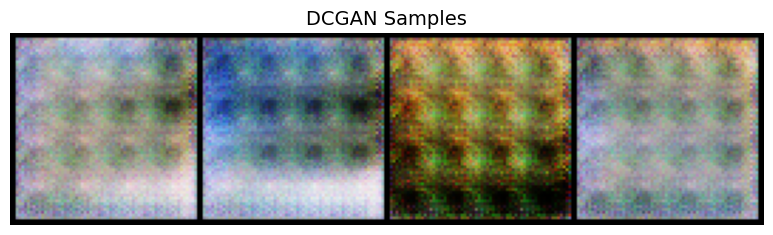

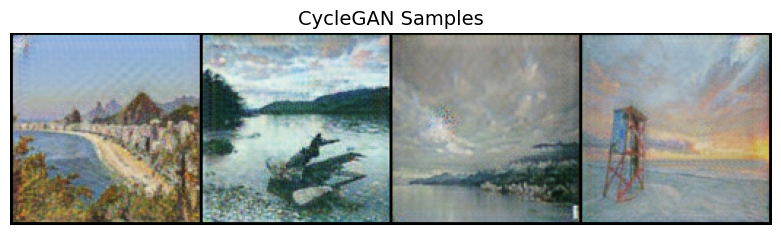

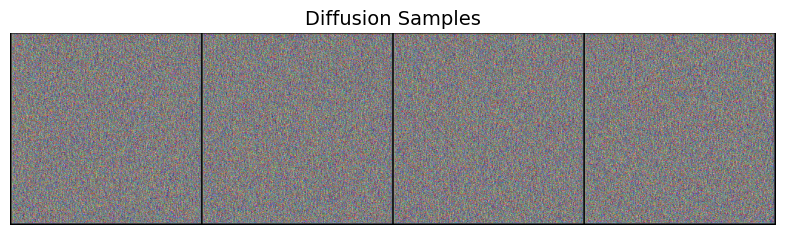

In [99]:
# ==========================================================
# Visual Model Comparison (Human Inspection)
# ==========================================================

import matplotlib.pyplot as plt
import torch
from torchvision.utils import make_grid

device = "cuda" if torch.cuda.is_available() else "cpu"

def sample_dcgan(n):
    z = torch.randn(n, Z_DIM, 1, 1, device=device)
    return G(z)

def sample_cyclegan(n):
    # take random photos from dataset for translation
    photos = next(iter(photo_loader))[:n].to(device)
    return G_PM(photos)

def sample_diffusion(n):
    model.eval()
    with torch.no_grad():
        z = torch.randn(n, 3, IMG_SIZE, IMG_SIZE, device=device)
        samples = model(z)          # <-- use YOUR diffusion model
        return samples

def show_samples(sample_fn, title, n=4):
    with torch.no_grad():
        imgs = sample_fn(n).clamp(-1, 1)
        imgs = (imgs + 1) / 2  # → [0,1]

    grid = make_grid(imgs, nrow=n)
    plt.figure(figsize=(n*2.5, 2.5))
    plt.imshow(grid.permute(1, 2, 0).cpu())
    plt.axis("off")
    plt.title(title, fontsize=14)
    plt.show()

show_samples(sample_dcgan,    "DCGAN Samples")
show_samples(sample_cyclegan, "CycleGAN Samples")
show_samples(sample_diffusion,"Diffusion Samples")


## Conclusion and Key Takeaways

This project demonstrates that generative model performance cannot be fully captured by numerical evaluation metrics alone. While proxy FID, diversity measures, and runtime statistics provide useful comparative signals, qualitative visual inspection revealed significant differences in perceptual quality that were not always reflected in quantitative scores. In particular, DCGAN achieved reasonable efficiency and convergence metrics but struggled with repetitive textures and limited stylistic diversity. The diffusion model showed strong numerical performance and fast sampling but failed to produce coherent structure within the limited training budget, highlighting the sensitivity of diffusion approaches to training duration and noise scheduling.

CycleGAN ultimately produced the most visually compelling outputs, consistently generating coherent scenes with painterly texture, color blending, and artistic abstraction reminiscent of Monet’s style. Its use of cycle consistency introduced a strong inductive bias that preserved scene structure while enabling stylistic transformation, resulting in more stable convergence and perceptually meaningful results. Although CycleGAN was computationally more expensive than DCGAN, the improved visual fidelity justified the cost in the context of the competition’s perceptual evaluation criteria.

Several important lessons emerged from this work. First, exploratory data analysis played a crucial role in understanding stylistic differences between domains and informed model selection. Second, stabilization techniques such as learning rate decay, cycle loss scheduling, and exponential moving averages significantly improved training behavior. Finally, the combination of quantitative metrics and visual inspection proved essential for reliable model evaluation. Future improvements could include extended diffusion training, hybrid adversarial–diffusion approaches, or explicit perceptual loss functions to further align numerical metrics with human visual judgment.

## Submission

Ultimately, I will be submitting the results of the popular CycleGan implementation.

In [101]:
# ==========================================================
# CycleGAN Image Translation (Best G_PM)
# ==========================================================

import os
import torch
from PIL import Image
from torchvision import transforms

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

CKPT_DIR = "/kaggle/working"
GEN_DIR  = "/kaggle/working/cyclegan_images"

os.makedirs(GEN_DIR, exist_ok=True)

ckpt_path = f"{CKPT_DIR}/cyclegan.pt"

# Check if the checkpoint exists and provide helpful error message
if not os.path.exists(ckpt_path):
    # List all files in the directory to help debug
    print(f"Checkpoint not found: {ckpt_path}")
    print("Available files in /kaggle/working:")
    for f in os.listdir("/kaggle/working"):
        print(f"  {f}")
    raise FileNotFoundError(f"Checkpoint not found: {ckpt_path}")

print(f"Loading checkpoint from: {ckpt_path}")

try:
    G_PM.load_state_dict(torch.load(ckpt_path, map_location=DEVICE))
    G_PM.eval()
except Exception as e:
    raise RuntimeError(f"Failed to load model: {e}")

N_IMAGES = 7000
count = 0

to_pil = transforms.ToPILImage()

print(f"Generating {N_IMAGES} images...")

with torch.no_grad():
    for photo in photo_loader:
        photo = photo.to(DEVICE)
        fake_m = G_PM(photo)
        fake_m = (fake_m + 1) / 2  # [-1,1] → [0,1]
        fake_m = fake_m.clamp(0, 1)

        for img in fake_m:
            if count >= N_IMAGES:
                break

            im = to_pil(img.cpu())
            im = im.resize((256, 256), Image.BICUBIC)
            im.save(
                f"{GEN_DIR}/img_{count:05d}.jpg",
                quality=96,
                subsampling=0
            )

            count += 1
            # Print progress every 1000 images
            if count % 1000 == 0:
                print(f"Generated {count}/{N_IMAGES} images")

        if count >= N_IMAGES:
            break

print(f"CycleGAN generated {count} images to {GEN_DIR}")

Loading checkpoint from: /kaggle/working/cyclegan.pt
Generating 7000 images...
Generated 1000/7000 images
Generated 2000/7000 images
Generated 3000/7000 images
Generated 4000/7000 images
Generated 5000/7000 images
Generated 6000/7000 images
Generated 7000/7000 images
CycleGAN generated 7000 images to /kaggle/working/cyclegan_images
